## Premier League Soccer/Football Data

The Football-Data Premier League Data [Dataset](https://www.football-data.co.uk/englandm.php) contains sports betting odds data from the 1993/1994 season to the 2022/2023 season. This website provides not only historical football results and betting odds, but also live scores, betting advice, and opportunities for people to bet themselves. The data is meant to be useful by providing insights over time -- insights that may be useful for making money off of identifying opportunities for arbitrage, instances where betting on all outcomes of a game is guaranteed to make a profit.

The data dictionary Notes.txt also provides descriptions for what each column means. There are two main groups of columns: game data and odds data. Firstly, columns relating to game data include the name of the home team, name of the away team, name of referree, shots on goal for each team, score, and number of yellow cards for each team. Secondly, there is odds data from multiple bookmakers and what the odds are for each outcome. Aside from specific odds for each outcome for each bookmaker, there is also some aggregate data such as average and maximum odds.

After cleaning data from 2010-2023 and doing some exploratory data analysis, the first step is to identify where there were opportunities for arbitrage to prepare for models to predict both whether there will be arbitrage opportunities as well as the profit margins.

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import datetime
import warnings
from matplotlib.cm import get_cmap
from matplotlib.ticker import FormatStrFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import math
warnings.filterwarnings("ignore")

In [61]:
%cd data

[Errno 2] No such file or directory: 'data'
/Users/emily/Desktop/ML/euro_soccer/data


In [62]:
# get file names of all data csvs in this folder
files = glob.glob("*.csv")

In [63]:
all_dfs = []
for file in files:
    try: 
        all_dfs.append(pd.read_csv(file, parse_dates = ["Date"], dayfirst = True))
    except: 
        print(file)
        continue
premier = pd.concat(all_dfs)

## Data Cleaning

In [64]:
print(premier.shape)
premier.head()

(4771, 139)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2013-08-17,Arsenal,Aston Villa,1.0,3.0,A,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2013-08-17,Liverpool,Stoke,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2013-08-17,Norwich,Everton,2.0,2.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2013-08-17,Sunderland,Fulham,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2013-08-17,Swansea,Man United,1.0,4.0,A,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
print("Taking data from", premier["Date"].min(), "to", premier["Date"].max())

Taking data from 2010-08-14 00:00:00 to 2023-02-08 00:00:00


In [66]:
premier = premier[(premier["HomeTeam"].notnull()) & premier["AwayTeam"].notnull()]

#### What are the odds like?

In [67]:
premier = premier[premier["Date"].notnull()]
premier["Year"] = premier["Date"].dt.year

In [68]:
home_odds_cols = ["B365H", "BSH", "BWH", "GBH", "IWH", "LBH", "PSH", "PH", "SOH",
                                            "SBH", "SJH", "SYH", "VCH", "WHH"]
draw_odds_cols = ["B365D", "BSD", "BWD", "GBD", "IWD", "LBD", "PSD", "PD", "SOD",
                                            "SBD", "SJD", "SYD", "VCD", "WHD"]
away_odds_cols = ["B365A", "BSA", "BWA", "GBA", "IWA", "LBA", "PSA", "PA", "SOA", 
                                            "SBA", "SJA", "SYA", "VCA", "WHA"]
h_odds_cols = list(set(premier.columns.tolist()).intersection(set(home_odds_cols)))
d_odds_cols = list(set(premier.columns.tolist()).intersection(set(draw_odds_cols)))
a_odds_cols = list(set(premier.columns.tolist()).intersection(set(away_odds_cols)))

In [69]:
def what_is_the_season(row):
    """
    For a given date of a match, get the season it was in.
    """
    date, year = row["Date"], row["Year"]

    if (date > datetime.date(year = year-1, day = 1, month = 8) and 
                    date <= datetime.date(year = year, day = 30, month = 5)):
        season = str(year-1) + "-" + str(year)
    else:
        season = str(year) + "-" + str(year + 1)
    
    return season

In [70]:
premier["Season"] = premier.apply(what_is_the_season, axis = 1)
def calc_avg_odd(year_subset):
    # Home
    home = year_subset[h_odds_cols]
    all_home_odds = home.values
    all_home_odds = [odd for odd in all_home_odds.flatten() if pd.notnull(odd)]
    avg_h = sum(all_home_odds)/len(all_home_odds)
    
    # Draw
    draw = year_subset[d_odds_cols]
    all_draw_odds = draw.values
    all_draw_odds = [odd for odd in all_draw_odds.flatten() if pd.notnull(odd)]
    avg_d = sum(all_draw_odds)/len(all_draw_odds)

    # Away
    away = year_subset[a_odds_cols]
    all_away_odds = away.values
    all_away_odds = [odd for odd in all_away_odds.flatten() if pd.notnull(odd)]
    avg_a = sum(all_away_odds)/len(all_away_odds)
    
    return [avg_h, avg_d, avg_a]

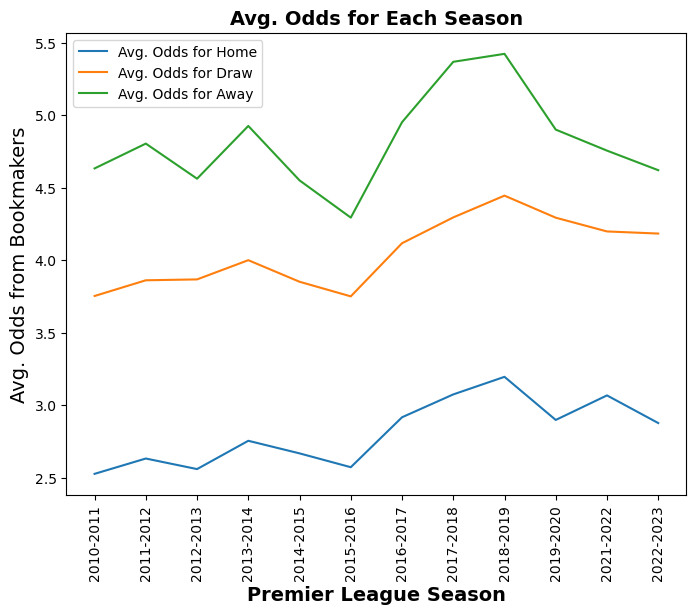

In [71]:
all_seasons = ['2010-2011', '2011-2012', '2012-2013', '2013-2014', 
               '2014-2015', '2015-2016', '2016-2017', '2017-2018',
               '2018-2019','2019-2020', '2021-2022', '2022-2023']

all_season_avg_odds = []
for season in all_seasons:
    season_data = premier[premier["Season"] == season]
    all_season_avg_odds.append(calc_avg_odd(season_data))
    
avg_odds_df = pd.DataFrame(all_season_avg_odds)
avg_odds_df.columns = ["Avg. Odds for Home", "Avg. Odds for Draw", "Avg. Odds for Away"]
avg_odds_df["Season"] = all_seasons
avg_odds_df = avg_odds_df[["Season", "Avg. Odds for Home", 
                           "Avg. Odds for Draw", "Avg. Odds for Away"]]

plt.figure(figsize = (8,6))
plt.plot(avg_odds_df["Season"], avg_odds_df["Avg. Odds for Home"], 
                                        label = "Avg. Odds for Home")
plt.plot(avg_odds_df["Season"], avg_odds_df["Avg. Odds for Draw"], 
                                        label = "Avg. Odds for Draw")
plt.plot(avg_odds_df["Season"], avg_odds_df["Avg. Odds for Away"], 
                                        label = "Avg. Odds for Away")
plt.legend()
plt.xticks(rotation='vertical')
plt.title("Avg. Odds for Each Season", fontsize = 14, fontweight = "bold")
plt.xlabel("Premier League Season", fontsize = 14, fontweight = "bold")
plt.ylabel("Avg. Odds from Bookmakers", fontsize = 14)
plt.show()
#plt.savefig("avg_odds_by_season.png", dpi = 400, bbox_inches = "tight")

In [72]:
# resume data cleaning

In [73]:
def drop_cols(df, miss_thresh = 0.5):
    """
    Drops columns in a dataframe where majority of data is missing.
    
    Inputs:
        df [Pandas df]: dataframe of game and odds data.
        miss_thresh [float]: if a column is missing more than 
        this proportion of values, it will be doppred. 
        
    Returns [Pandas df]: a new dataframe without those columns.
    """

    max_missing = len(df) * miss_thresh
    to_drop = df.isna().sum().loc[lambda miss: miss > max_missing].index.tolist()
    to_keep = list(set(df.columns).difference(set(to_drop)))
    print("Dropped", len(to_drop), "columns")
    return df[to_keep]

In [74]:
premier = drop_cols(premier)

Dropped 74 columns


In [75]:
def fill_miss(df):
    """
    Fill missing values in columns with mean of that column. 
    
    Inputs:
        df [Pandas df]: The dataframe to be cleaned.
        
    Returns [Pandas df]: a new dataframe with no missing values.
    """
    
    cols_to_fill = df.isna().sum()[df.isna().sum() > 0].index.tolist()
    for col in cols_to_fill:
        df[col] = df[col].fillna(df[col].mean())
        
    return df

In [76]:
premier = fill_miss(premier)

## Exploratory Data Analysis

#### What are the scores like in soccer?

In [77]:
premier["Score Difference"] = abs(premier["FTHG"] - premier["FTAG"])
score_diff = pd.DataFrame(premier["Score Difference"].value_counts())
score_diff.reset_index(inplace = True)
score_diff.columns = ["Score Diff.", "# of Games"]
score_diff.sort_values(by = "Score Diff.", inplace = True)

In [78]:
premier["Diff. in Shots on Target"] = abs(premier["HST"] - premier["AST"])
shots_diff = pd.DataFrame(premier["Diff. in Shots on Target"].value_counts())
shots_diff.reset_index(inplace = True)
shots_diff.columns = ["Shots Diff.", "# of Games"]
shots_diff.sort_values(by = "Shots Diff.", inplace = True)

As the team that is home and away changes every game, it does not make sense to consider the variables for home team score and away team score independently, or the home team shots on goal and away team shots on goal independently. 

Taking the absolute value of the difference between the goals and shots on goal for each team is more meaningful for visualization.

In [79]:
mean_score_diff = np.mean(premier["Score Difference"])
mean_shots_diff = np.mean(premier["Diff. in Shots on Target"])
print("Mean Score Difference: ", np.round(mean_score_diff, 3))
print("Mean Shots Difference: ", np.round(mean_shots_diff, 3))

Mean Score Difference:  1.41
Mean Shots Difference:  3.4


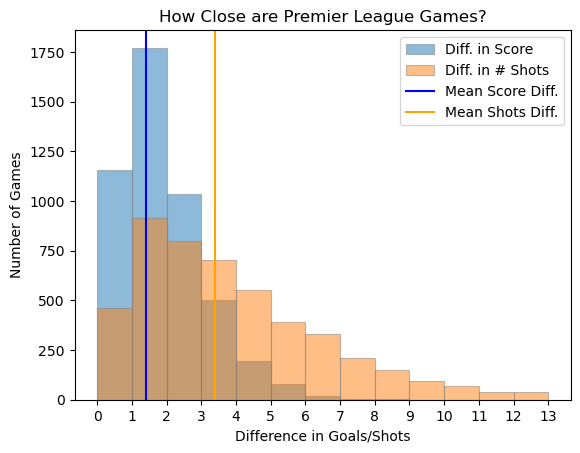

In [80]:
#| fig-cap: Visualization of the distribution of difference in goals in all Premier League games, as well as the distribution of the difference in shots on goal in all games.
plt.rcParams["figure.dpi"] = 100
plt.title("How Close are Premier League Games?")
plt.hist(premier["Score Difference"], bins = np.arange(0, 10, 1),
    edgecolor = "gray", linewidth = 0.8, alpha = 0.5, label = "Diff. in Score")
plt.hist(premier["Diff. in Shots on Target"], bins = np.arange(0, 14, 1), 
    edgecolor = "gray", linewidth = 0.8, alpha = 0.5, label = "Diff. in # Shots")
plt.xlabel("Difference in Goals/Shots")
plt.ylabel("Number of Games")
plt.axvline(x = mean_score_diff, color = "blue", label = "Mean Score Diff.")
plt.axvline(x = mean_shots_diff, color = "orange", label = "Mean Shots Diff.")
plt.xticks(np.arange(0, 14, 1))
plt.legend()
plt.show()

As opposed to other sports such as Basketball, in soccer games are often won by 1 or 2 goals.

In order to compare two teams, it is also useful to look at other statistics such as number of shots on goal, number of minutes of possession by each team, and even number of corner kicks by each team (as a proxy for understanding how often the ball is near the goal of the opposing team).

#### Which teams are good?

In [81]:
game_res = pd.get_dummies(premier["FTR"])
premier = pd.concat([premier, game_res], axis = 1)
teams = set(premier["HomeTeam"].unique()).union(set(premier["AwayTeam"]))
print("There are ", len(teams), "teams in the Premier League: ", teams)

There are  39 teams in the Premier League:  {'Newcastle', 'Blackpool', 'Brentford', 'Sheffield United', 'Crystal Palace', 'Sunderland', 'Hull', 'Brighton', "Nott'm Forest", 'Southampton', 'Leicester', 'Cardiff', 'Blackburn', 'Norwich', 'West Ham', 'West Brom', 'QPR', 'Birmingham', 'Leeds', 'Man City', 'Fulham', 'Reading', 'Aston Villa', 'Wolves', 'Arsenal', 'Huddersfield', 'Bournemouth', 'Watford', 'Chelsea', 'Swansea', 'Burnley', 'Bolton', 'Liverpool', 'Wigan', 'Everton', 'Man United', 'Stoke', 'Tottenham', 'Middlesbrough'}


In [82]:
def num_wins_each_team(df):
    """
    Returns a dataframe summarizing Win/Loss/Draw results by each team.
    """
    cols_to_make = ["Team Name", "Home Wins", "Home Losses", "Home Draws", 
        "Away Wins","Away Losses", "Away Draws", "Total Wins", "Total Losses", 
        "Total Draws"]
    all_team_res = []
    # global variable teams
    for team in teams: 
        # When the team is the home team
        team_is_playing_home = df[df["HomeTeam"] == team]
        num_wins_as_home, num_loss_as_home = sum(team_is_playing_home["H"]), sum(team_is_playing_home["A"])
        num_draws_as_home = sum(team_is_playing_home["D"])
        # When the team is the away team
        team_is_playing_away = df[df["AwayTeam"] == team]
        num_wins_as_away, num_loss_as_away = sum(team_is_playing_away["A"]), sum(team_is_playing_away["H"])
        num_draws_as_away = sum(team_is_playing_away["D"])
        # Totals
        tot_wins = num_wins_as_home + num_wins_as_away
        tot_loss = num_loss_as_home + num_loss_as_away
        tot_draws = num_draws_as_home + num_draws_as_away

        
        that_team_stats = [team, num_wins_as_home, num_loss_as_home, 
                             num_draws_as_home, num_wins_as_away, num_loss_as_away, 
                             num_draws_as_away, tot_wins, 
                             tot_loss, tot_draws]

        all_team_res.append(that_team_stats)
    
    res = pd.DataFrame(all_team_res, columns = cols_to_make)
    res["Prop. of Wins are Home"] = res["Home Wins"]/(res["Home Wins"] + res["Away Wins"])
    res["Prop. of Home are Wins"] = res["Home Wins"]/(res["Home Wins"] + res["Home Draws"] + res["Home Losses"])
    res["Prop. of Away are Wins"] = res["Away Wins"]/(res["Away Wins"] + res["Away Draws"] + res["Away Losses"])

    return res

In [83]:
by_team = num_wins_each_team(premier)
by_team.sort_values(by = "Total Wins", ascending = False, inplace = True)
by_team.reset_index(inplace = True, drop = True)

In [84]:
#| fig-cap: The teams with the most total wins in the Premier League.
by_team[["Team Name", "Total Wins"]].head()

,Team Name,Total Wins
0,Man City,325
1,Liverpool,268
2,Man United,267
3,Chelsea,264
4,Arsenal,260


In [85]:
# Save data by team to Excel. Could be incorporated for future analysis to interpret results of ML models.
#by_team.to_excel("team_performances.xlsx", index = False)

### Logistic Regression: Predicting Arbtirage after the fact

Using game data and one-hot encoded team names, referee, and year data as features, predicting whether there is an arbitrage opportunity or not. Admittedly, this is not that meaningful of a prediction to make since it is predicting whether there was an arbitrage opportunity both after the window to place bets elapsed as well as predicting after the results of the game are known. However, there is a lack of pre-game data specific to each game as well as a lack of mergable historical premier league player statistic datasets.

In [101]:
prem.sort_values(by = "Date", inplace = True)
prem["Year"] = prem["Date"].dt.year
year_one_hot = pd.get_dummies(prem["Year"], prefix = "Year")

In [102]:
cols_to_get = ["HS", "AS", "HST", "AST", "HHW", "AHW", "HC", "AC", "HF",
        "AF", "HFKC", "AFKC", "HO", "AO", "HY", "AY", "HR", "AR",
        "FTHG", "HG", "FTAG", "AG", "Res", "HTHG", "HTAG"]

num_cols = [col for col in cols_to_get if col in prem.columns.tolist()]
num_data = prem[num_cols]
home_one_hot = pd.get_dummies(prem["HomeTeam"], prefix = "Home")
away_one_hot = pd.get_dummies(prem["AwayTeam"], prefix = "Away")
ref_one_hot = pd.get_dummies(prem["Referee"], prefix = "ref")
for_lr = pd.concat([num_data, home_one_hot, away_one_hot, ref_one_hot, year_one_hot], axis = 1)
for_lr.shape

(4770, 150)

In [103]:
X = for_lr.values
y = prem["Arbitrage Opportunity"]

In [104]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.33, random_state = 99)

In [105]:
X_tr.shape, X_te.shape

((3195, 150), (1575, 150))

In [106]:
# According to the sklearn documentation, newton-cholesky is a good choice when there are more observations than features,
# especially when there are one-hot encoded categorical features with rare categories, which is applicable for team name and 
#referree name especially.
logreg_arb = LogisticRegression(solver = "newton-cholesky", random_state = 10)
logreg_arb.fit(X_tr, y_tr)
y_pred_arb = logreg_arb.predict(X_te)
log_reg_arb_acc = accuracy_score(y_te, y_pred_arb)

In [107]:
#| fig-cap: For the test set, this is the class breakdown for the variable that is being predicted
pd.DataFrame(np.round(pd.DataFrame(y_te)["Arbitrage Opportunity"].value_counts()/len(y_te), 4))

,Arbitrage Opportunity
True,0.6476
False,0.3524


In [108]:
print("Logistic Regression Model to Predict Opportunity for Arbitrage after knowing game results has an Accuracy of: ", np.round(log_reg_arb_acc, 4))

Logistic Regression Model to Predict Opportunity for Arbitrage after knowing game results has an Accuracy of:  0.8546


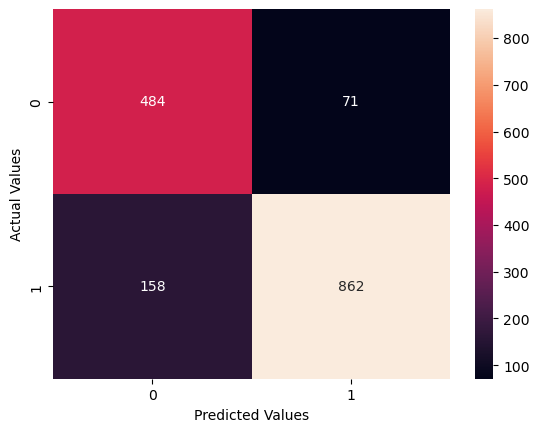

In [109]:
cfm_arb = confusion_matrix(y_te, y_pred_arb)
sns.heatmap(cfm_arb, annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()